In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine =create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
conn=engine.connect()

In [7]:
# reflect an existing database into a new model
Base= automap_base()
Base.prepare(engine,reflect=True)

# reflect the tables

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Inspection

In [11]:
#Establish Inspector
inspector=inspect(engine) 

#Measurment Columns
Measurement_Columns=inspector.get_columns('measurement')

for columns in Measurement_Columns:
    print(columns['name'])

id
station
date
prcp
tobs


In [12]:
#Station Columns
Station_Columns=inspector.get_columns('station')

for columns in Station_Columns:
    print(columns['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

In [13]:
# Calculate the date 1 year ago from the last data point in the database
last=session.query(Measurement).order_by(Measurement.date.desc()).limit(1).all()
last_date= " " 

for info in last:
    last_date=info

print(last_date.date)

2017-08-23


In [14]:
first_day=dt.date(2017,8,23)-dt.timedelta(days=365)

In [15]:
results=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>= first_day).all()

In [16]:
percip_df=pd.DataFrame(results, columns=['date', 'percip'])
percip_df.set_index(['date'], inplace=True)
final_df= percip_df.sort_values('date')
final_df.head()

,percip
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


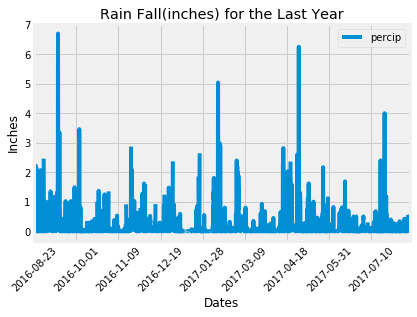

In [17]:
final_df.plot(rot=45)
plt.xlabel('Dates')
plt.ylabel('Inches')
plt.title('Rain Fall(inches) for the Last Year')
plt.show()

In [18]:
final_df.describe()

,percip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(Station.id)).all()

print(f'There is a total of {station_count[0][0]} stations')

There is a total of 9 stations


In [20]:
stations=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
most_active=stations[0][0]
station_data=session.query(Measurement.tobs).filter(Measurement.station==most_active).all()

#Lowest Temp
min_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active).all()

#Highest Temp
max_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active).all()

#Average Temp
avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()

print(f'The lowest temp recorded is: {min_temp[0][0]}°F')
print(f'The highest temp recorded is: {max_temp[0][0]}°F')
print(f'The average temp is: {round(avg_temp[0][0],2)}°F')

The lowest temp recorded is: 54.0°F
The highest temp recorded is: 85.0°F
The average temp is: 71.66°F


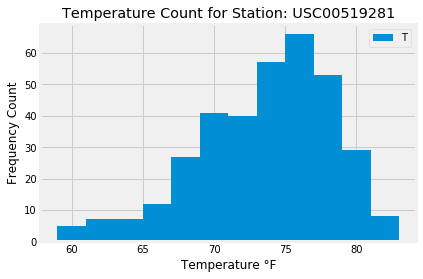

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stations=session.query(Measurement.tobs).filter(Measurement.station==most_active)\
.filter(Measurement.date>= first_day).all()

#Collect numbers into a list
results=[int(info[0]) for info in stations]

#Plot Graph
plt.hist(results, bins=12)
plt.xlabel('Temperature °F')
plt.ylabel('Frequency Count')
plt.title(f'Temperature Count for Station: {most_active}')
plt.legend('Temperature')
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps=calc_temps(first_day,last_date.date)

print(f' Min: {temps[0][0]}°F, AVG: {round(temps[0][1],2)}°F, Max: {temps[0][2]}°F')

 Min: 58.0°F, AVG: 74.59°F, Max: 87.0°F
